# Bayesian Linear Regression

A probabilistic view of a linear regression offers advantages comparing with a frequencist treatment of the linear regression model as seen in the previous labs. Let's discuss the differences between the two approaches looking at an example with data on [Kaggle](https://www.kaggle.com/). Before that, let us formally introduce some concepts and notation; I will follow your lecture's notation and the flow of section 3.3 of [Chris Bishop's Book](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).

Start by considering a standard linear regression model written as 

$$
y = X w + \varepsilon,
$$ 

Where $X \in \mathbb{R}^{n \times d}$ is a matrix of inputs, $y \in \mathbb{R}^n$ is a vector of outputs, $w \in \mathbb{R}^{d}$ a vector of parameters. 

Recall from your lecture that, we have assumed for simplicity that in a Bayesian setting we have

* **Likelihood:** $y \sim N(Xw, \sigma^2 I) $
* **Prior:** $w \sim N(0,\lambda^{-1}I)$

For Bayesians any unknown quantity is treated as random and therefore, contrary to standard linear regression, $w$ is vector of random variables here. This different way to think about $w$ leads to the need of specifying its 'Prior' distribution that reflects our prior belief on $w$. Here we assume a Gaussian prior for simplicity, but you can specify other types of distribution that best reflect your prior knowledge about the DGP. 

Bayesian inference then proceeds by estimating the posterior which according to the Bayes Rule is proportional to the Likelihood times the Prior, i.e. 

$$
p(w|y,X) \propto p(y|w,X)p(w).
$$

The $\propto$ sign indicates that the quantities in both sides are proportional to each other. One important thing to notice is that, while in the standard linear regression estimation yields a point estimate of $w$ (and respective standard deviation), Bayesians report a distribution instead (i.e. $p(w|y,X)$) from which one can calculate moments (eg. mean, standard deviation). 

Given our choice of Prior, it turns out that in this case

$$
p(w|y,X) = N(w|\mu, \Sigma). 
$$

with 

$$
\Sigma = (\lambda I + \sigma^{-2} X'X)^{-1},\\
\mu = (\lambda \sigma^{2} I +  X'X)^{-1} X'y.
$$

Bayesian inference often involves Markov-Chain Monte Carlo (MCMC) algorithms such as the Gibbs Sampler or Metropolis Hastings which can be computationally expensive as model complexity grows. Variational Bayes (VB) methods are also popular as they don't require simulation to compute posterior distributions and can therefore be faster. These alternative methods of inference are often necessary since the posterior distribution is of an unknown form. 

However, in specific cases (such as the one above) where you have very simple models and conjugate priors, it may be possible to obtain a closed-form solution for the posterior distribution. Conjugate priors are chosen so that the posterior distribution belongs to the same family of distributions as the prior, simplifying the maths. These cases are the exception rather than the rule. 

Maximizing the log posterior wrt. $w$ gives the maximum-a-posterior (MAP) estimate.

In summary, while there are cases where you can obtain a closed-form solution for the posterior distribution in Bayesian linear regression, it is more common to use numerical methods like MCMC or VB to approximate the posterior distribution, especially in complex and real-world scenarios. These numerical methods provide a flexible and powerful way to estimate the Bayesian posterior when closed-form solutions are not available.


### Exercise
Think about how the previous solution compares with OLS estimators. 

Now let's see an example where we try and predict house prices in California with a Bayesian Linear Model. 

In [1]:
# load required libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

In [2]:
data_cali_hp = fetch_california_housing(as_frame=True)
print(data_cali_hp.DESCR) #<- uncomment to read a brief data description
data_cali_hp = data_cali_hp.frame
#data_cali_hp.info()
#data_cali_hp.head()


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

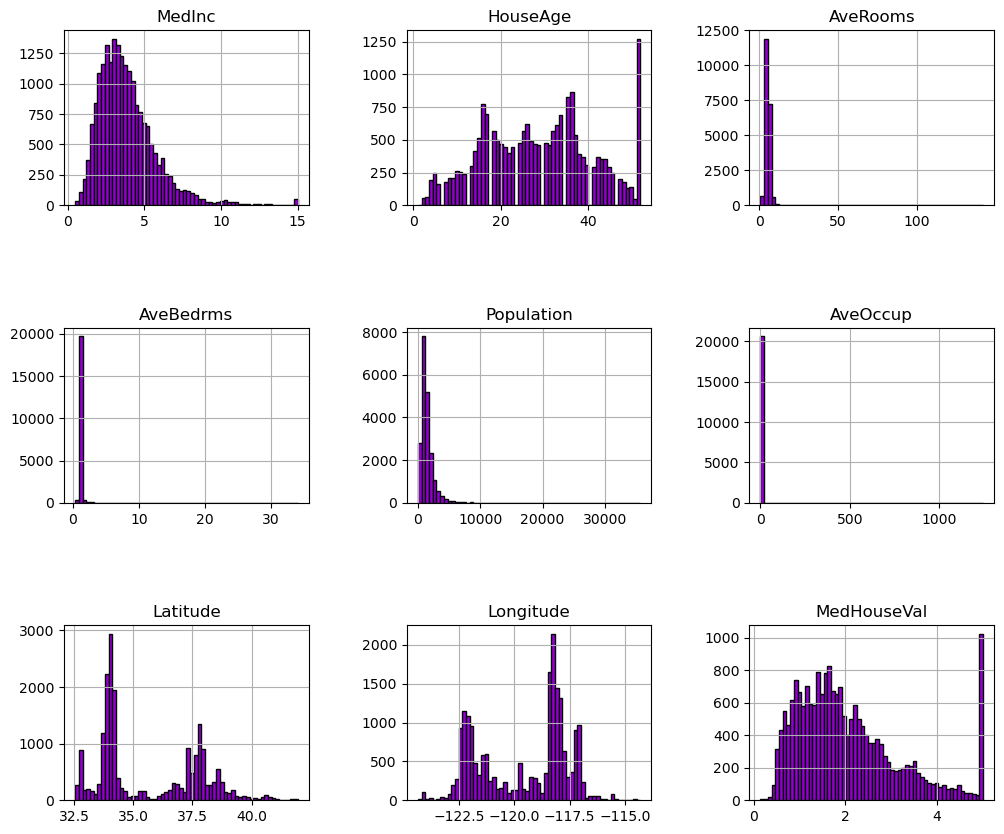

In [3]:
# Describe the data
data_cali_hp.hist(bins=60, edgecolor="black", figsize=(12, 10),color='darkviolet')
plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.show()

We can first focus on features for which their distributions would be more or less expected.

The median income is a distribution with a long tail. It means that the salary of people is more or less normally distributed but there is some people getting a high salary.

Regarding the average house age, the distribution is more or less uniform.

The target distribution has a long tail as well. In addition, we have a threshold-effect for high-valued houses: all houses with a price above 5 are given the value 5.

Focusing on the average rooms, average bedrooms, average occupation, and population, the range of the data is large with unnoticeable bin for the largest values. It means that there are very high and few values (maybe they could be considered as outliers?). We can see this specificity looking at the statistics for these features:

In [4]:
features_of_interest = ["AveRooms", "AveBedrms", "AveOccup", "Population"]
data_cali_hp[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


For each of these features, comparing the interquartile range, we can see a huge difference. It confirms the intuitions that there are a couple of extreme values.

Up to know, we discarded the longitude and latitude that carry geographical information. In short, the combination of this feature could help us to decide if there are locations associated with high-valued houses. Indeed, we could make a scatter plot where the x- and y-axis would be the latitude and longitude and the circle size and color would be linked with the house value in the district.

In [5]:
#! pip install geopandas geoplot
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
' Plot Two Geopandas Plots Side by Side '
# defining a simple plot function, input list containing features of names found in dataframe
def plotTwo(df,lst):
    
    # load california from module, common for all plots
    cali = gpd.read_file(gplt.datasets.get_path('california_congressional_districts'))
    cali = cali.assign(area=cali.geometry.area)
    
    # Create a geopandas geometry feature; input dataframe should contain .longtitude, .latitude
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.Longitude,df.Latitude))
    proj=gcrs.AlbersEqualArea(central_latitude=37.16611, central_longitude=-119.44944) # related to view

    ii=-1
    fig,ax = plt.subplots(1,2,figsize=(21,6),subplot_kw={'projection': proj})
    for i in lst:

        ii+=1
        tgdf = gdf.sort_values(by=i,ascending=True) 
        gplt.polyplot(cali,projection=proj,ax=ax[ii]) # the module already has california 
        gplt.pointplot(tgdf,ax=ax[ii],hue=i,cmap='plasma',legend=True,alpha=1.0,s=3) # 
        ax[ii].set_title(i)

    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.5)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_8728\3254044107.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cali = cali.assign(area=cali.geometry.area)
C:\Users\Miguel\AppData\Local\Temp\ipykernel_8728\3254044107.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cali = cali.assign(area=cali.geometry.area)


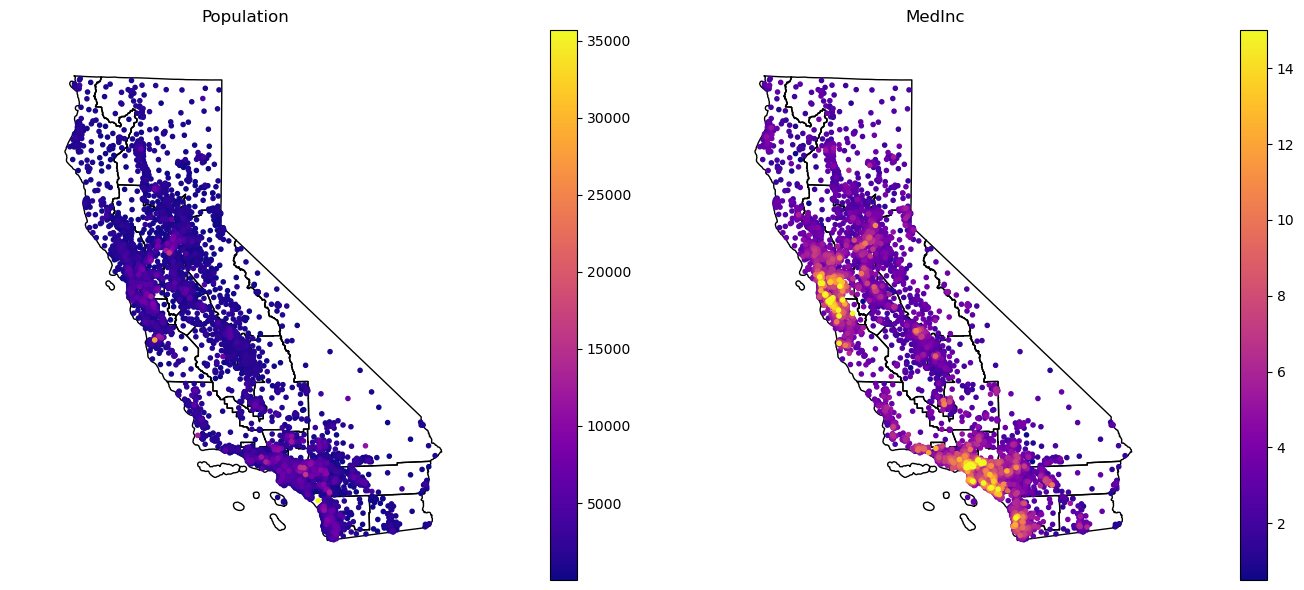

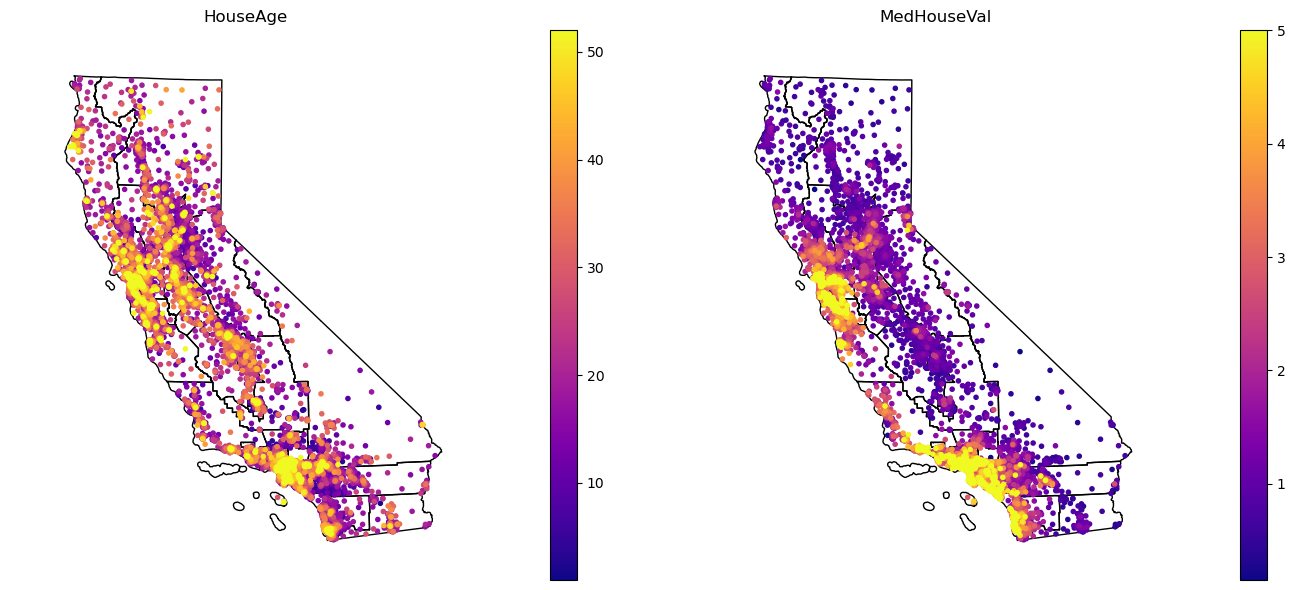

In [6]:
# Call function that plots two geopandas plots 
plotTwo(data_cali_hp,['Population','MedInc'])
plotTwo(data_cali_hp,['HouseAge','MedHouseVal'])
#del data_cali_hp['geometry'] # not useful for anything other than gpd visualisation

If you are not familiar with the state of California, it is interesting to notice that all datapoints show a graphical representation of this state. The high-valued houses will be located on the coast, where the big cities from California are located: San Diego, Los Angeles, San Jose, or San Francisco.

Let's make a final analysis by making a pair plot of all features and the target but dropping the longitude and latitude. We will remove the target such that we can create proper histogram.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns

# Take a random sample of the data to acelerate plotting 
rng = np.random.RandomState(0)
indices = rng.choice(
    np.arange(data_cali_hp.shape[0]), size=500, replace=False
)

# Drop the unwanted columns
columns_drop = ["Longitude", "Latitude"]
subset = data_cali_hp.iloc[indices].drop(columns=columns_drop)
# Quantize the target and keep the midpoint for each interval
subset["MedHouseVal"] = pd.qcut(subset["MedHouseVal"], 6, retbins=False)
subset["MedHouseVal"] = subset["MedHouseVal"].apply(lambda x: x.mid)

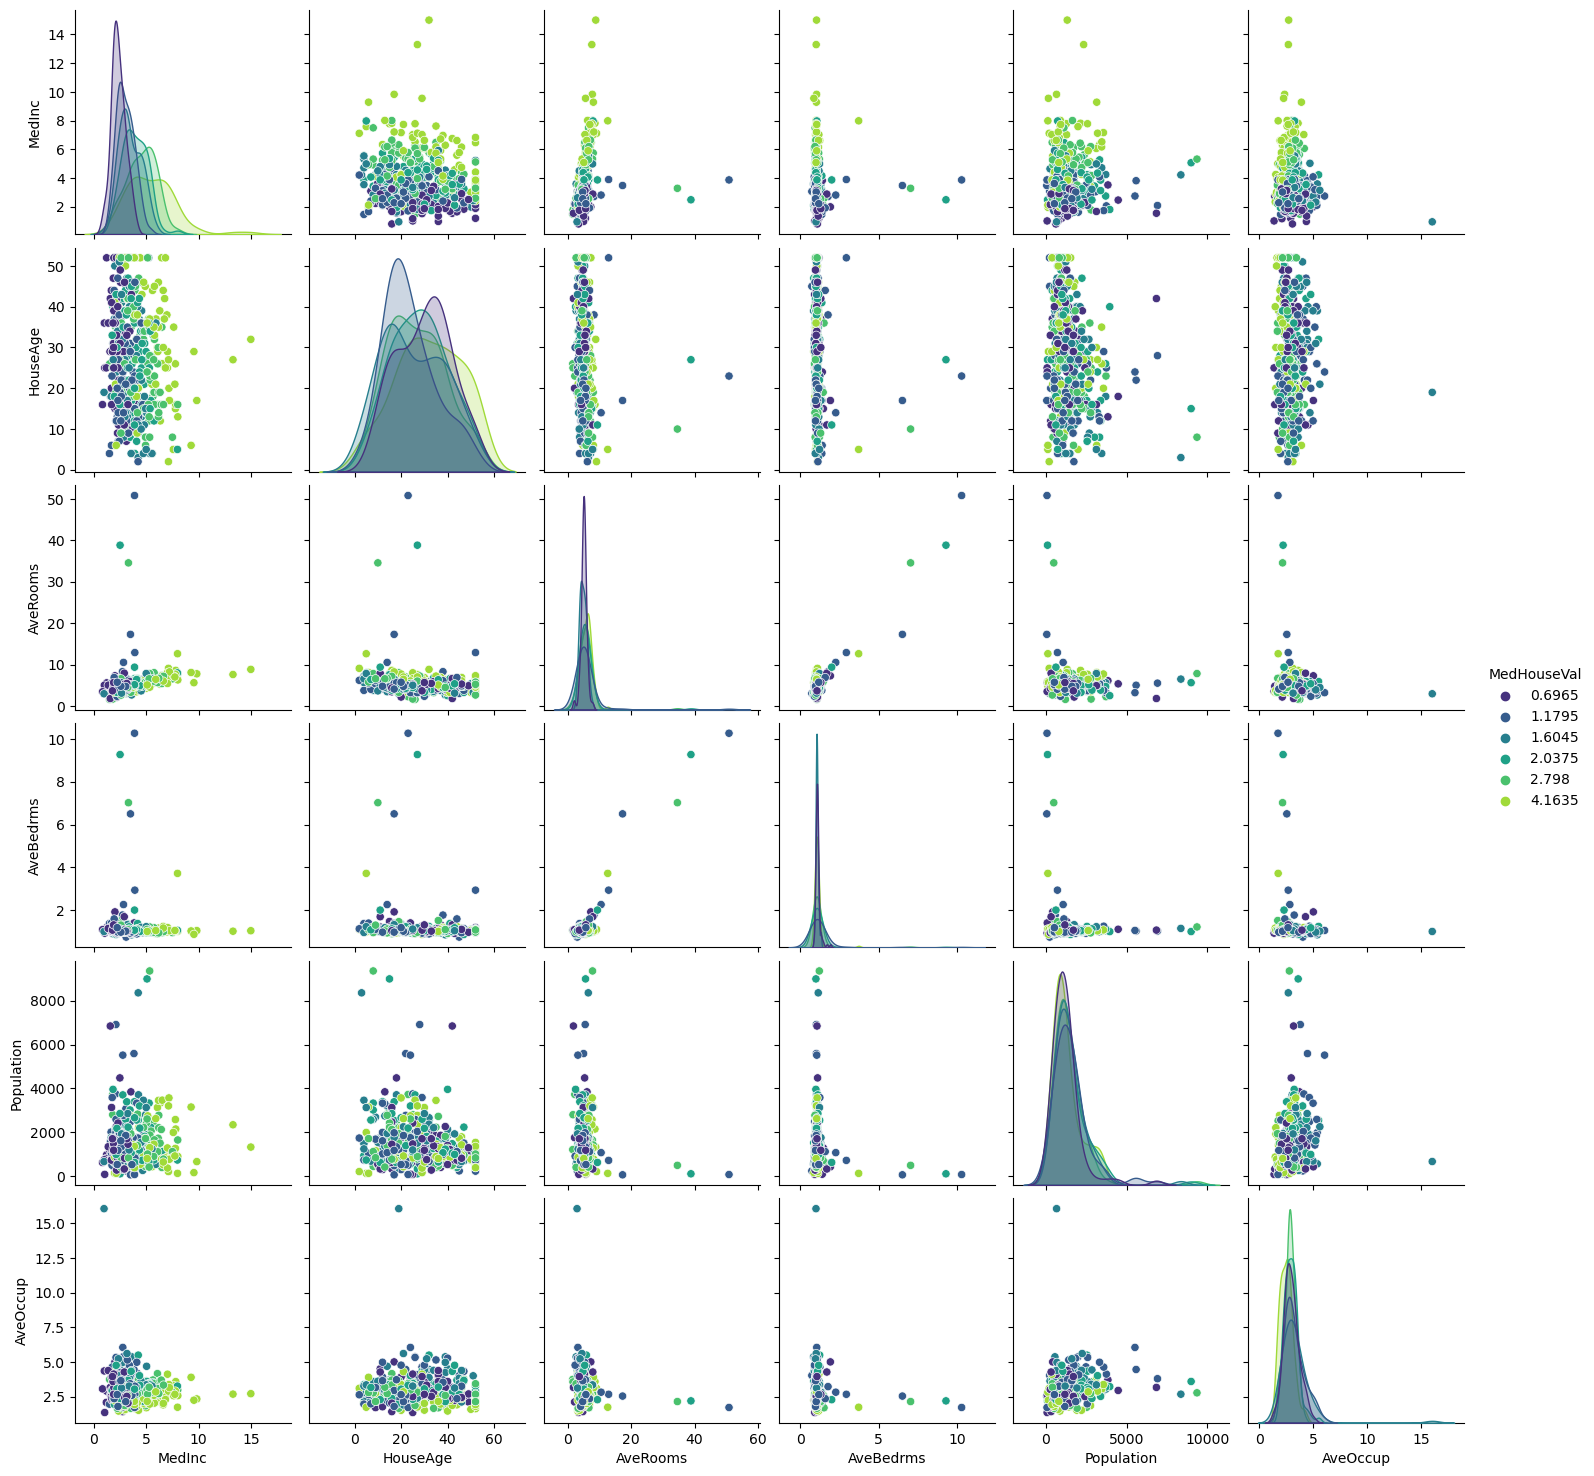

In [8]:
_ = sns.pairplot(data=subset, hue="MedHouseVal", palette="viridis")

Looking at descriptive statistics helps build some intuition for the data and think about the predictive model we want to setup. We can for instance notice the presence of outliers, and see that the median income is helpful to distinguish high-valued from low-valued houses. It is reasonable to expect the longitude, latitude, and the median income to be useful features in predicting the median house values.

### Predicting House Values

Let's setup a Bayesian Linear Regression model to try and predict house prices in Cali. 

In [9]:
from sklearn.linear_model import BayesianRidge, LinearRegression

X = data_cali_hp.copy()
y = np.exp(data_cali_hp['MedHouseVal']) # <- typically we keep the log to run the regression. Here I take the exp{} so that coeffs are meaningful.
LRM = LinearRegression()
BLR = BayesianRidge()
BLR.fit(X, y)
LRM.fit(X, y)

# Create a DataFrame to store the coefficients
coefficients_df = pd.DataFrame({
    'Feature': X.columns,  # Assuming X contains column names
    'Linear Regression Coefficient':  LRM.coef_,
    'Bayesian Ridge Coefficient': BLR.coef_
})

# Display the coefficients
print(coefficients_df)


       Feature  Linear Regression Coefficient  Bayesian Ridge Coefficient
0       MedInc                       1.634156                    1.632060
1     HouseAge                       0.175638                    0.175636
2     AveRooms                      -2.077023                   -2.069044
3    AveBedrms                       8.571035                    8.532918
4   Population                      -0.000657                   -0.000657
5     AveOccup                      -0.001491                   -0.001493
6     Latitude                       8.749902                    8.739650
7    Longitude                       8.726341                    8.716120
8  MedHouseVal                      26.761079                   26.753811


Note that the Bayesian Linear Regression that we described is sometimes called Bayesian Ridge due to the Gaussian Priors put on the weights $w$. These priors penalize large values of the coefficients. For this specific data, both seem to give very similar results although this needs not be the case. Notice also that, in the above example we totally disregarded the hyperparameters $\lambda$ and $\sigma$. It turns out that, when using `BayesianRidge()` if you don't specify their values, Python will automatically define uninformative Gamma hyperpriors. However, you can also specify hyperparameter if you have a strong opinion about what the value of a specific coefficient should be.

### Exercise 

Calculate the predicted value of a house for a household with average features, using the model above.

In [10]:
data_cali_hp.mean().values

array([ 3.87067100e+00,  2.86394864e+01,  5.42899974e+00,  1.09667515e+00,
        1.42547674e+03,  3.07065516e+00,  3.56318614e+01, -1.19569704e+02,
        2.06855817e+00])

In [11]:
np.exp(BLR.predict([data_cali_hp.mean().values]))

c:\Users\Miguel\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BayesianRidge was fitted with feature names
  warnings.warn(


array([1.30271218e+08])

Let's write a DIY machine learning model pipeline to help us compare predictive performance. 

In [12]:
import warnings
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

def suppress_warnings():
    warnings.filterwarnings('ignore')

# Model Evaluation Pipeline w/ Cross Validation
def modelEval(datah,feature='MedHouseVal',model_id = 'dummy'):
    
    
    # Input: Feature & Target DataFrame
    # Split feature/target variable
    y = datah[feature].copy()
    X = datah.copy()
    del X[feature]     # remove target variable

    suppress_warnings()
    # Pick Model 
    if(model_id == 'dummy'):    model = DummyRegressor()
    if(model_id == 'BLR'):      model = BayesianRidge(verbose=False) # <- set to false for minimalist output
    if(model_id == 'LR'):       model = LinearRegression() 
    ''' Standard Cross Validation '''
    cv_score = np.sqrt(-cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error'))
    print("RMSE:",cv_score);print("Mean across k-fold:", cv_score.mean());print("std:", cv_score.std())


In [13]:
# A simple comparison of models
modelEval(data_cali_hp,model_id='dummy')
modelEval(data_cali_hp,model_id='BLR')
modelEval(data_cali_hp,model_id='LR')

RMSE: [1.14300564 1.09495832 1.25408734 1.12189797 1.23064605]
Mean across k-fold: 1.1689190658050883
std: 0.06231618587595042
RMSE: [0.69598835 0.78910253 0.80387139 0.73723379 0.70327065]
Mean across k-fold: 0.7458933435919393
std: 0.04384216713047099
RMSE: [0.69631786 0.78898504 0.80387217 0.73702076 0.70333835]
Mean across k-fold: 0.7459068363518117
std: 0.04373972167592658


### Exercise 

Why are the results identical for the Linear Regression and Bayesian Linear Regression ? Tweek the pipeline to allow for a much wider range of models within the linear regression model seen in previous labs. Make sure you include the Ridge, Lasso and Elastic Net. Compare the RMSE and comment. 

### Automatic Relevance Determination Regression

Automatic Relevance Determination (ARD) Regression is a kind of Bayesian Linear Regression that leads to a sparser solution for $w$. 

It is best thought as a prior rather than a regression. It drops the spherical Gaussian distribution for a centered elliptic Gaussian distribution. What does that mean ? Each coefficient $w_i$ can be independently drawn from a Gaussian distribution, centered in zero and with precision $\lambda_i$. Thus,

$$
p(w|\lambda) = N(w|0,A^{-1}),
$$

with A being a positive definite diagonal matrix and $\lambda = diag(A) = (\lambda_1,...,\lambda_d)$. Contrary to the standard Bayesian Linear Regression we introduced, here each element $w_i$ has its own standard deviation $1/ \lambda_i$. 

Again, here $\lambda$ is a hyperparameter which can be set by the econometrician with expert knwoledge about the DGP. However, when using `ARDRegression()` from `sklearn`, by default Gamma priors are specified. ARD is also known in the literature as Sparse Bayesian Learning and Relevance Vector Machine (see Section 7.2.1 of [Chris Bishop's Book](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) )

Let's now see how the ARD Prior leads to different results with our dataset.

In [14]:
from sklearn.linear_model import ARDRegression

ard = ARDRegression(compute_score=True, n_iter=30).fit(X, y)
coefficients_df['ARDRegression'] = ard.coef_

coefficients_df

,Feature,Linear Regression Coefficient,Bayesian Ridge Coefficient,ARDRegression
0,MedInc,1.634156,1.632060,1.615543
1,HouseAge,0.175638,0.175636,0.194449
2,AveRooms,-2.077023,-2.069044,-2.013981
3,AveBedrms,8.571035,8.532918,8.394052
4,Population,-0.000657,-0.000657,0.000000
5,AveOccup,-0.001491,-0.001493,0.000000
6,Latitude,8.749902,8.739650,8.836697
7,Longitude,8.726341,8.716120,8.790180
8,MedHouseVal,26.761079,26.753811,26.780613


### Bayesian regressions with polynomial feature expansion



In [59]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Take a random sample of the data to acelerate plotting 
rng = np.random.RandomState(0)
indices = rng.choice(
    np.arange(data_cali_hp.shape[0]), size=100, replace=False
)

X = data_cali_hp[['MedInc']].iloc[indices].copy()
y = np.exp(data_cali_hp['MedHouseVal'].iloc[indices]) # <- typically we keep the log to run the regression. Here I take the exp{} so that coeffs are meaningful.

blr_poly = make_pipeline(
    PolynomialFeatures(degree=1, include_bias=False),
    StandardScaler(),
    BayesianRidge(),
).fit(X, y)
ard_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    ARDRegression(),
).fit(X, y)
brr_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    BayesianRidge(),
).fit(X, y)

y_ard, y_ard_std = ard_poly.predict(X, return_std=True)
y_brr, y_brr_std = brr_poly.predict(X, return_std=True)
y_blr, y_blr_std = blr_poly.predict(X, return_std=True)

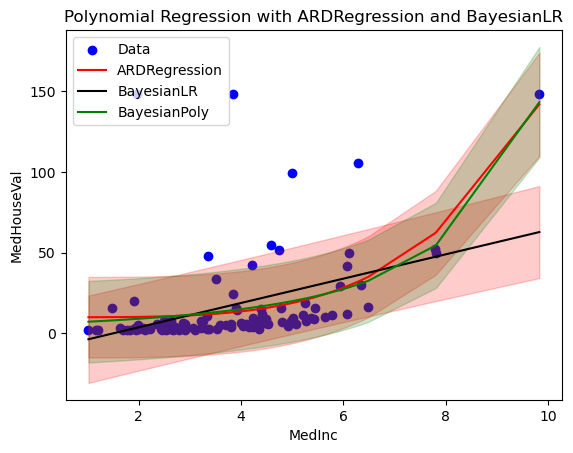

In [62]:
import matplotlib.pyplot as plt

# Original data points
plt.scatter(X, y, label='Data', color='b')

# Sort X for a smoother plot
X_plot = np.sort(X, axis=0)

# Predictions and standard deviations for ARDRegression
y_ard, y_ard_std = ard_poly.predict(X_plot, return_std=True)
plt.plot(X_plot, y_ard, label='ARDRegression', color='r')
plt.fill_between(X_plot[:, 0], y_ard - y_ard_std, y_ard + y_ard_std, color='r', alpha=0.2)

# Predictions and standard deviations for ARDRegression
y_blr, y_blr_std = blr_poly.predict(X_plot, return_std=True)
plt.plot(X_plot, y_blr, label='BayesianLR', color='k')
plt.fill_between(X_plot[:, 0], y_blr - y_blr_std, y_blr + y_blr_std, color='r', alpha=0.2)

# Predictions and standard deviations for BayesianRidge
y_brr, y_brr_std = brr_poly.predict(X_plot, return_std=True)
plt.plot(X_plot, y_brr, label='BayesianPoly', color='g')
plt.fill_between(X_plot[:, 0], y_brr - y_brr_std, y_brr + y_brr_std, color='g', alpha=0.2)

plt.xlabel('MedInc')
plt.ylabel('MedHouseVal')
plt.legend(loc='upper left')
plt.title('Polynomial Regression with ARDRegression and BayesianLR')
plt.show()


### Exercise

Use the `make_pipeline` function to construct MSE for the three models in the previous example. Which one returns the best in-sample fit ? 

## References

Some good resources for further study:

<a id='id27'></a>
 [Christopher M. Bishop. *Pattern Recognition and Machine Learning*. Springer, 2006.](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)

<a id='id26'></a>
[Pace, R. Kelley and Ronald Barry. *Sparse Spatial Autoregressions*, Statistics and Probability Letters, 33 ,1997 291-297.](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)




<a id='app-reg-ex'></a>
